In [1]:
import os 
os.chdir("../..")

In [2]:
import numpy as np
#from detectron2.structures import BoxMode
import cv2
import matplotlib.pyplot as plt


from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from src.utils.dataset import register_detectron2_multipart_datasets
from src.utils.training import get_splits_for_multipart_dataset, SickTreesNDVIAugmentedTrainer, SickTreesDatasetMapper
from src.detection.rgb_ndvi_retinanet import RGB_NDVI_RetinaNet

In [3]:
!ls data/training/RGBN

lubsko		swiebodzin  torzym		       zagan
sulechow_slawa	szprotawa   train_val_test_splits.pkl


In [4]:
base_path = "data/training/RGBN/"
train_val_maps = ["szprotawa", "swiebodzin", "lubsko", "zagan", "torzym"]
test_maps = ["sulechow_slawa"]

In [5]:
splits = get_splits_for_multipart_dataset(base_path, train_val_maps, test_maps)

In [8]:
register_detectron2_multipart_datasets("sick_trees", 
                                       {m: base_path + m for m in train_val_maps},
                                       splits, min_bbox_area=200)

In [9]:
meta = MetadataCatalog.get('sick_trees_train')

In [10]:
%%time
train_dataset_dicts = DatasetCatalog.get("sick_trees_train")
len(train_dataset_dicts)

CPU times: user 12.3 s, sys: 2.89 ms, total: 12.3 s
Wall time: 12.3 s


22090

In [11]:
%%time
val_dataset_dicts = DatasetCatalog.get("sick_trees_val")
len(val_dataset_dicts)

CPU times: user 3.65 s, sys: 7.96 ms, total: 3.66 s
Wall time: 3.66 s


5483

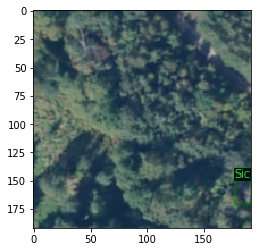

In [13]:
smpl = np.random.choice(val_dataset_dicts, 1)
for d in smpl:
    img = cv2.imread(d["file_name"], cv2.IMREAD_UNCHANGED)#[:, :, ::-1]
    visualizer = Visualizer(img[:,:,:3], metadata=meta, scale=0.75)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [14]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir tboard_logs

Reusing TensorBoard on port 6006 (pid 3854), started 0:28:41 ago. (Use '!kill 3854' to kill it.)

In [15]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [16]:
from datetime import datetime

In [14]:
cfg = get_cfg()

# cfg.OUTPUT_DIR = "tboard_logs/test_test_2020-02-22T23:14/"
cfg.OUTPUT_DIR = f"./tboard_logs/rgb_ndvi_retinanet_augm_{datetime.now().isoformat().rsplit(':', 1)[0]}/"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("sick_trees_train",)
cfg.DATASETS.TEST = ("sick_trees_val",)

cfg.DATALOADER.NUM_WORKERS = 4

cfg.INPUT.MIN_SIZE_TRAIN = (256,)
cfg.INPUT.MIN_SIZE_TEST = (256,)

cfg.MODEL.META_ARCHITECTURE = 'RGB_NDVI_RetinaNet'
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.MODEL.RETINANET.NUM_CLASSES = 1

# cfg.MODEL.PIXEL_MEAN = [103.53, 116.28, 123.675, 187.153] #ostatnia wartość wpisana z palca
cfg.MODEL.PIXEL_STD =  [1.0, 1.0, 1.0, 1.0]
cfg.MODEL.PIXEL_MEAN = [68.60176277048289, 90.37255792238817, 99.04053918695983, 187.12327778336686]
# cfg.MODEL.PIXEL_STD = [25.05072945688351, 22.96708310183466, 13.27640256812483, 10.55706656507702]


cfg.SOLVER.IMS_PER_BATCH = 2 # 32
cfg.SOLVER.BASE_LR = 0.001 # 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 600_000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical data

cfg.SOLVER.WARMUP_ITERS = 2500
cfg.SOLVER.GAMMA = 0.3
cfg.SOLVER.STEPS = (100_000, 200_000, 300_000, 400_000, 500_000)

cfg.SOLVER.CHECKPOINT_PERIOD = 50_000


# cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)

cfg.TEST.EVAL_PERIOD = 3000 # 5000 #200
cfg.TEST.DETECTIONS_PER_IMAGE = 10

cfg.VIS_PERIOD = 100

Loading config /home/mkosturek/miniconda3/envs/geopython37/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [15]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open(cfg.OUTPUT_DIR + "/config.yml", "w") as f:
    f.write(cfg.dump())

In [ ]:
# %%capture train_history
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = SickTreesNDVIAugmentedTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[02/23 11:16:02 d2.engine.defaults]: Model:
RGB_NDVI_RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
   

'backbone.bottom_up.stem.conv1.weight' has shape (64, 3, 7, 7) in the checkpoint but (64, 4, 7, 7) in the model! Skipped.
'head.cls_score.weight' has shape (720, 256, 3, 3) in the checkpoint but (9, 256, 3, 3) in the model! Skipped.
'head.cls_score.bias' has shape (720,) in the checkpoint but (9,) in the model! Skipped.


[02/23 11:16:15 d2.engine.train_loop]: Starting training from iteration 0
[02/23 11:16:17 d2.utils.events]: eta: 9:23:23  iter: 19  total_loss: 1.958  loss_cls: 1.125  loss_box_reg: 0.839  time: 0.0574  data_time: 0.0093  lr: 0.000009  max_mem: 554M
[02/23 11:16:18 d2.utils.events]: eta: 9:25:52  iter: 39  total_loss: 1.670  loss_cls: 1.082  loss_box_reg: 0.567  time: 0.0568  data_time: 0.0034  lr: 0.000017  max_mem: 554M
[02/23 11:16:19 d2.utils.events]: eta: 9:24:51  iter: 59  total_loss: 1.536  loss_cls: 1.017  loss_box_reg: 0.516  time: 0.0567  data_time: 0.0033  lr: 0.000025  max_mem: 554M
[02/23 11:16:20 d2.utils.events]: eta: 9:23:14  iter: 79  total_loss: 1.424  loss_cls: 0.949  loss_box_reg: 0.491  time: 0.0566  data_time: 0.0032  lr: 0.000033  max_mem: 554M
[02/23 11:16:21 d2.utils.events]: eta: 9:22:53  iter: 99  total_loss: 1.341  loss_cls: 0.859  loss_box_reg: 0.444  time: 0.0565  data_time: 0.0031  lr: 0.000041  max_mem: 554M
[02/23 11:16:22 d2.utils.events]: eta: 9:22:35

In [39]:
1+2

3

In [23]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")


cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3
cfg.DATASETS.TEST = ("sick_trees_val", )
# cfg.TEST.SCORE_THRESHOLD = 0.3
# cfg.TEST.SCORE_THRESH_TEST = 0.3
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3


cfg.TEST.DETECTIONS_PER_IMAGE = 10
predictor = DefaultPredictor(cfg)

predictor.cfg["TEST"]

CfgNode({'EXPECTED_RESULTS': [], 'EVAL_PERIOD': 5000, 'KEYPOINT_OKS_SIGMAS': [], 'DETECTIONS_PER_IMAGE': 10, 'AUG': CfgNode({'ENABLED': False, 'MIN_SIZES': (400, 500, 600, 700, 800, 900, 1000, 1100, 1200), 'MAX_SIZE': 4000, 'FLIP': True}), 'PRECISE_BN': CfgNode({'ENABLED': False, 'NUM_ITER': 200})})

In [24]:
with open(cfg.OUTPUT_DIR + "/config.yml", "w") as f:
    f.write(cfg.dump())

In [43]:
torch.as_tensor([im.transpose(2,0,1)]).shape

torch.Size([1, 3, 256, 256])

In [46]:
from src.utils.training import DatasetMapper

In [52]:
mapper = DatasetMapper(cfg, False)

In [54]:
predictor.model([mapper(d)])

[{'instances': Instances(num_instances=0, image_height=256, image_width=256, fields=[pred_boxes = Boxes(tensor([], device='cuda:0', size=(0, 4))), scores = tensor([], device='cuda:0', grad_fn=<IndexBackward>), pred_classes = tensor([], device='cuda:0', dtype=torch.int64), ])}]

In [28]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("sick_trees_val")

In [33]:
im.shape

(256, 256, 3)

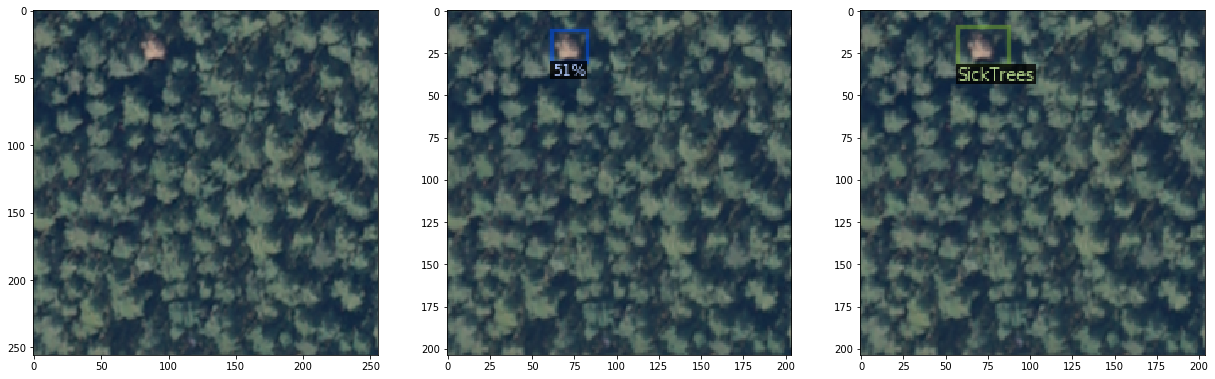

In [69]:
import time
for d in np.random.choice(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
#     outputs = predictor(im)
    with torch.no_grad():
        outputs = predictor.model([mapper(d)])[0]
    v = Visualizer(im[:,:,::-1].copy(),
                   metadata=meta, 
                   scale=0.8)
    
    vis = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    f, a = plt.subplots(1,3, figsize=(21,7))
    a[0].imshow(im[:,:,::-1])
    a[1].imshow(vis.get_image())
    
    v = Visualizer(im[:,:,::-1].copy(),
                   metadata=meta, 
                   scale=0.8)
    vis = v.draw_dataset_dict(d)
    a[2].imshow(vis.get_image())

In [54]:
_ = register_detectron2_datasets("szprott", "./data/szprotawa_patches_256/", 0.7, 0.15, 0.15, 100, {'test': splits['test'][:500]})

TypeError: register_detectron2_datasets() takes from 3 to 5 positional arguments but 7 were given

In [73]:
from detectron2.evaluation import DatasetEvaluator, COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader



evaluator = COCOEvaluator("sick_trees_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
# val_loader = build_detection_test_loader(cfg, "sick_trees_val")
val_loader = trainer.build_test_loader(cfg, "sick_trees_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[02/21 14:38:54 d2.evaluation.evaluator]: Start inference on 4030 images
[02/21 14:38:54 d2.evaluation.evaluator]: Inference done 11/4030. 0.0224 s / img. ETA=0:01:34
[02/21 14:38:59 d2.evaluation.evaluator]: Inference done 238/4030. 0.0208 s / img. ETA=0:01:23
[02/21 14:39:04 d2.evaluation.evaluator]: Inference done 465/4030. 0.0208 s / img. ETA=0:01:18
[02/21 14:39:09 d2.evaluation.evaluator]: Inference done 693/4030. 0.0207 s / img. ETA=0:01:13
[02/21 14:39:14 d2.evaluation.evaluator]: Inference done 920/4030. 0.0208 s / img. ETA=0:01:08
[02/21 14:39:19 d2.evaluation.evaluator]: Inference done 1146/4030. 0.0208 s / img. ETA=0:01:03
[02/21 14:39:24 d2.evaluation.evaluator]: Inference done 1373/4030. 0.0208 s / img. ETA=0:00:58
[02/21 14:39:29 d2.evaluation.evaluator]: Inference done 1603/4030. 0.0207 s / img. ETA=0:00:53
[02/21 14:39:34 d2.evaluation.evaluator]: Inference done 1834/4030. 0.0207 s / img. ETA=0:00:48
[02/21 14:39:40 d2.evaluation.evaluator]: Inference done 2066/4030. 0

OrderedDict([('bbox',
              {'AP': 35.45761232461119,
               'AP50': 81.04746984694792,
               'AP75': 23.948007144000407,
               'APs': 25.56586011222921,
               'APm': 44.29292329496553,
               'APl': 59.15053211845841})])